In [101]:
import tensorflow as tf
import numpy as np 
import os 
from PIL import Image
from tensorflow.keras.preprocessing.image import smart_resize
import matplotlib.pyplot as plt
import numpy.random as rng
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as tf_reg 
import tensorflow.keras.backend as K

## Step 1: Load data 

In [102]:
path = "./siemese_data/train"
img_size = (124, 124)

def load_siemese_imgs(path, img_size):
    x = []    # x will be the image data from the different servant classes 
    y = []    # y will be the label of the servants, from 0-n_classes
    curr_y = 0 # used to keep track of the label of the image
    
    for servant in os.listdir(path): 
        if not ".DS" in servant: 
            print("loading: {0} with label {1}".format(servant, curr_y))
            
            serv_path = os.path.join(path, servant)
            serv_imgs = []  # stores all images of the particular servant class
            for file in os.listdir(serv_path):
                if not ".DS" in file: 
                    img_path = os.path.join(serv_path, file)
                    img = Image.open(img_path).convert('RGB')   #load servant cards in grayscale since color won't matter
                    img = np.array(img)
                    img = tf.image.rgb_to_grayscale(img)
                    img = smart_resize(img, img_size) / 255   # resize and normalize image 
                    serv_imgs.append(img) 
                    y.append(curr_y)
            x.append(np.stack(serv_imgs))
            curr_y += 1
    
    x = np.stack(x)
    y = np.vstack(y)
    return x, y 

X, y = load_siemese_imgs(path, img_size)

print(X.shape)
print(y.shape)
        

loading: jalter with label 0
loading: nito with label 1
loading: dantes with label 2
loading: mash with label 3
loading: ishtar_summer with label 4
loading: shiki with label 5
loading: ozy with label 6
loading: saber with label 7
loading: hokusai with label 8
loading: cu with label 9
loading: eresh with label 10
loading: raikou with label 11
loading: regend with label 12
loading: karna with label 13
loading: ishtar with label 14
loading: musashi with label 15
loading: napoleon with label 16
loading: waver with label 17
loading: tamamo with label 18
loading: wu with label 19
(20, 3, 124, 124, 1)
(60, 1)


## Step 2: Map data to siemese network with a generator

In [103]:
# we want a data set where each element is ((img1, img2), label)
# label is 0 if they are different, 1 if they are the same servant

# so we have to create pairs of images, with a label, then we will turn that processed array into a dataset
# we want to have a balanced dataset, so create pairs of half same, half different 
# Below is a python generator which creates batches of random pairs, 50% of each classification class

def get_siemese_batch(batch_size, x): 
    n_classes, n_examples, w, h, _ = x.shape
    if n_classes < batch_size:
        batch_size = n_classes
        
    # randomly select servants to use in the batch
    servants = rng.choice(n_classes, size=(batch_size,), replace=False)
    
    # 2 empty arrays for input image batch
    pairs=[np.zeros((batch_size, h, w, 1)) for i in range(2)]
    # 1 array for the target 
    labels = np.zeros((batch_size,))
    labels[batch_size//2:] = 1 # make half of the labels different, half the same
    
    for i in range(batch_size):
        servant = servants[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i, :, : ,:] = x[servant, idx_1].reshape(w, h, 1) 
        
        # if we are in the second half of the batch, generate from same servant
        if i >= batch_size //2: 
            servant_2 = servant 
        else:
            servant_2 = (servant + rng.randint(1, n_classes)) % n_classes
            
        idx_2 = rng.randint(0, n_examples)
        pairs[1][i, :, :, :] = x[servant_2, idx_2].reshape(w, h, 1)
        
    return pairs, labels

# the actual generator function just wraps the get batch function
def batch_gen(batch_size, x):
    while True: 
        pairs_in, labels = get_siemese_batch(batch_size, x)
        yield (pairs_in, labels)

gen = batch_gen(8, X)
pairs, lables = next(gen)

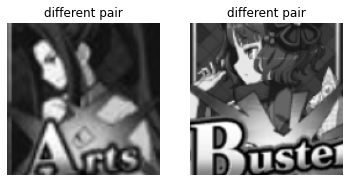

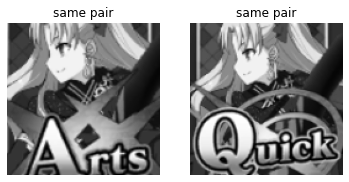

In [104]:
# function to check generated batches 
def plot_siemese_batch(batch, img_size= (124,124), diff=True, pair_switch_index=5):
    if diff:
        pair_type = 0 
        title = "different pair"
    else:
        title = "same pair"
        pair_type = pair_switch_index
    plt.figure()
    imgs, labels = next(batch)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(pairs[0][pair_type].reshape(124,124), cmap="gray")
    plt.title(title)
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(pairs[1][pair_type].reshape(124,124), cmap="gray")
    plt.title(title)
    plt.axis("off")
    
plot_siemese_batch(gen)
plot_siemese_batch(gen, diff=False)

## Step 3: Create the network and compile it 

In [105]:

def simple_siemese_net(input_shape):
    # two inputs for the image pair 
    left_in = tf.keras.Input(input_shape)
    right_in = tf.keras.Input(input_shape)
    
    # set up the convolution network for feature extraction (shared weights)
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(10,10), activation="relu", 
                           input_shape=input_shape,
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=128, kernel_size=(8,8), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=128, kernel_size=(4,4), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4),
                           ))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(filters=256, kernel_size=(4,4), activation="relu",
                           kernel_regularizer=tf_reg.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation="sigmoid",
                   kernel_regularizer=tf_reg.l2(1e-3)))
    
    # get the outputs for the pair of inputs
    encoded_l = model(left_in)
    encoded_r = model(right_in)
    
    # custom layer to computer absolute difference between encodings 
    L1_layer = layers.Lambda(lambda t:K.abs(t[0] - t[1]))
    abs_diff = L1_layer([encoded_l, encoded_r])
    
    # prediction layer 0-1 confidence 
    prediction = layers.Dense(1, activation="sigmoid")(abs_diff)
    
    # compile the network using the functional API 
    siamese_net = tf.keras.Model(inputs=[left_in, right_in], outputs=prediction)
    
    return siamese_net

In [106]:
input_shape = img_size + (1,)
model = simple_siemese_net(input_shape)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 124, 124, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 124, 124, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         18099008    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[0][0]    

In [107]:
# binary loss since there are 2 classes: same pair, different pair
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=5e-4)

model.compile(loss=loss_fn, optimizer=optimizer)

## Step 4: Create a custom training loop and train 

In [108]:
def plot_pair(pair):
    plt.figure()
    ax = plt.subplot(1, 2, 1)
    plt.imshow(pair[0].reshape(124,124), cmap="gray")
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(pair[1].reshape(124,124), cmap="gray")
    plt.axis("off")

In [147]:
# accuracy evaluation function for training 
def eval_acc(model, generator, plot=False):
    n_correct = 0
    pairs, targets = next(generator)
    preds = model.predict_on_batch(pairs)
    for i in range(len(pairs[0])):
        print("prediction: ", preds[i])
        if preds[i] <= 0.5:
            if targets[i] == 0:
                n_correct += 1
            elif plot:
                print("classified as different")
                print("prediction: ", preds[i])
                plot_pair([pairs[0][i], pairs[1][i]])
        else:
            if targets[i] == 1:
                n_correct += 1
            elif plot:
                print("classified as same")
                print("prediction: ", preds[i])
                plot_pair([pairs[0][i], pairs[1][i]])
    return n_correct/ len(pairs[0])

# test the accuracy function: 
ds_gen = batch_gen(16, X)
acc = eval_acc(model, ds_gen)
print(acc)

prediction:  [0.00375521]
prediction:  [0.011121]
prediction:  [0.0428288]
prediction:  [0.35526443]
prediction:  [0.01206756]
prediction:  [0.20894712]
prediction:  [0.07752338]
prediction:  [0.00828031]
prediction:  [0.7428295]
prediction:  [0.5059748]
prediction:  [0.5059748]
prediction:  [0.5059748]
prediction:  [0.5059748]
prediction:  [0.8086532]
prediction:  [0.8509964]
prediction:  [0.72730255]
1.0


an accuracy around 0.5 makes since, the model is untrained with a binary problem

In [131]:
# training function that saves models with better accuracy 

def train_with_gen(generator, model, X, V, eval_every=2, loss_every=1, epochs=10, batch_size = 16):
    batch_generator = generator(batch_size, X)
    val_generator = generator(batch_size, V)
    best = eval_acc(model, val_generator) # the current best accuracy
    print("current_best: ", best)
    i = 0 # keep track of how many batches 
    while(i < epochs):
        pairs, labels = next(batch_generator)
        loss = model.train_on_batch(pairs, labels)
        val_acc = eval_acc(model, val_generator)
        if i % eval_every == 0:
            if val_acc > best:
                print("saving val_acc: ", val_acc)
                model.save('curr_best_clean')
                best=val_acc
        if i % loss_every == 0:
            train_acc = eval_acc(model, batch_generator)
            print("epoch {0}, training loss: {1:.2f}, train acc: {2:.2f}, val acc: {3:.2f}".format(i,loss, train_acc, val_acc))
        
        i += 1 

In [132]:
# load the validation set like we did the training set
val_path = "./siemese_data/val_"
V, v_y = load_siemese_imgs(val_path, img_size)

loading: ryouma with label 0
loading: banana_summer with label 1
loading: jeanne with label 2
loading: skadi with label 3


In [133]:
train_with_gen(batch_gen, model, X, V)

current_best:  0.75
saving val_acc:  0.75
INFO:tensorflow:Assets written to: curr_best_clean/assets
epoch 0, training loss: 1.83, train acc: 0.81, val acc: 1.00
epoch 1, training loss: 1.68, train acc: 1.00, val acc: 1.00
epoch 2, training loss: 1.70, train acc: 0.94, val acc: 1.00
epoch 3, training loss: 1.63, train acc: 0.94, val acc: 1.00
epoch 4, training loss: 1.54, train acc: 1.00, val acc: 1.00
epoch 5, training loss: 1.48, train acc: 1.00, val acc: 1.00
epoch 6, training loss: 1.67, train acc: 0.94, val acc: 1.00
epoch 7, training loss: 1.41, train acc: 0.81, val acc: 1.00
epoch 8, training loss: 1.45, train acc: 0.81, val acc: 1.00
epoch 9, training loss: 1.35, train acc: 0.94, val acc: 1.00


prediction:  [0.08860415]
prediction:  [0.83316815]
classified as same
prediction:  [0.83316815]
prediction:  [0.5059748]
prediction:  [0.47197703]
classified as different
prediction:  [0.47197703]
0.5


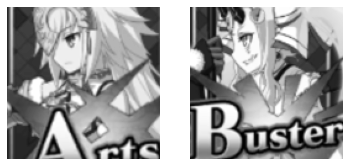

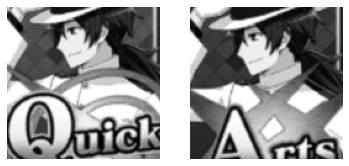

In [157]:
# after a round of training let's check what the model is getting wrong 
val_gen = batch_gen(4, V)
acc = eval_acc(model, val_gen, plot=True)
print(acc)

In [137]:
# more training 
train_with_gen(batch_gen, model, X, V)

current_best:  0.75
epoch 0, training loss: 1.14, train acc: 1.00, val acc: 0.75
epoch 1, training loss: 1.03, train acc: 0.94, val acc: 0.75
epoch 2, training loss: 0.98, train acc: 1.00, val acc: 0.75
epoch 3, training loss: 0.98, train acc: 0.94, val acc: 1.00
saving val_acc:  0.75
INFO:tensorflow:Assets written to: curr_best_clean/assets
epoch 4, training loss: 0.90, train acc: 0.94, val acc: 1.00
epoch 5, training loss: 1.03, train acc: 0.81, val acc: 0.75
epoch 6, training loss: 1.02, train acc: 0.94, val acc: 1.00
epoch 7, training loss: 0.95, train acc: 0.94, val acc: 0.75
epoch 8, training loss: 0.99, train acc: 1.00, val acc: 0.75
epoch 9, training loss: 0.90, train acc: 0.94, val acc: 0.75


In [158]:
# the model is not very confident, but we see that the dantes pair is never messed up, this is fine since the 
# validation set is so different from the training set 